# 实验代码

## obstacle and map

In [1]:
# 获取参数
%matplotlib inline
import matplotlib.pyplot as plt  
from math import sqrt,exp
from random import randint,random
from  my_motion_planning_toolbox import *
import os
from queue import PriorityQueue
# https://www.jianshu.com/p/eaa1bf01b3a6
import yaml
def generate_yaml_doc(yaml_file,py_object):
    file = open(yaml_file, 'w', encoding='utf-8')
    yaml.dump(py_object, file)
    file.close()
def get_yaml_data(yaml_file):
    # 打开yaml文件
    file = open(yaml_file, 'r', encoding="utf-8")
    file_data = file.read()
    file.close()
    # 将字符串转化为字典或列表
    data = yaml.safe_load(file_data)
    print(data)
    return data
# Load Global Variable
current_path = os.path.abspath(".")
yaml_path = os.path.join(current_path, "my_motion_roadmap.yaml")
data = get_yaml_data(yaml_path)
CIRCLE_R = data['CIRCLE_R']  # 机器人以及动态障碍物的半径(假设都是圆)
POINT_GOAL = tuple(data['POINT_GOAL'])  # 全局目标
POINT_START = tuple(data['POINT_START'])  # 全局起始点
DYNAMIC_DEFAULT_COLOR = tuple(data['DYNAMIC_DEFAULT_COLOR'])  # 动态障碍物的颜色
DYNAMIC_VISIBLE_R = data['DYNAMIC_VISIBLE_R']  # 人的可视范围(假设是方形区域)的半径
REACH_GOAL_THRESHOLD = data['REACH_GOAL_THRESHOLD']
ROBOT_SPEED = data['ROBOT_SPEED']  # 机器人的速度
ROBOT_COLOR = tuple(data['ROBOT_COLOR'])  # 机器人的颜色
ROBOT_VISIBLE_R = data['ROBOT_VISIBLE_R']  # 机器人的可视范围(假设是方形区域)的半径
num_key = data['num_key']
ROBOT_CONTROL = data['ROBOT_CONTROL']
STEP_REWARD = data['STEP_REWARD']  # 机器人走一步的代价
COLLISION_REWARD = data['COLLISION_REWARD']  # 机器人发生碰撞的代价
REACH_GOAL_REWARD = data['REACH_GOAL_REWARD']  # 机器人到达终点的奖励
MAX_ATTRACTIVE = data['MAX_ATTRACTIVE']
DISTANCE_NEIGHBOR = data['DISTANCE_NEIGHBOR'] #边的最长距离
EDGE_COLOR = data['EDGE_COLOR']
Q1 = data['Q1'] #路径长度在NewCost比较中的权重
Q2 = data['Q2'] #危险系数在NewCost比较中的权重
delta = data['delta']
#counting time
import time
import functools
def clock(func):
    @functools.wraps(func) 
    def clocked(*args, **kwargs):
        """this is inner clocked function"""
        start_time = time.time()
        result = func(*args, **kwargs)
        time_cost = time.time() - start_time
        print(func.__name__ + " func time_cost -> {}" + str(time_cost))
        return result
    return clocked 
# @functools.lru_cache()  
#@clock  
#def function():

{'APF_WAY': 3, 'D_MAX': 90, 'OBSTACLE_MAX': 255, 'ROU': 20}
{'CIRCLE_R': 10, 'COLLISION_REWARD': -10, 'DISTANCE_NEIGHBOR': 200, 'EDGE_COLOR': 127, 'Q1': 0.5, 'Q2': 0.5, 'delta': 0.02, 'DYNAMIC_DEFAULT_COLOR': [0, 0, 255], 'DYNAMIC_VISIBLE_R': 150, 'MAX_ATTRACTIVE': 707, 'POINT_GOAL': [490, 10], 'POINT_START': [10, 250], 'REACH_GOAL_REWARD': 100, 'REACH_GOAL_THRESHOLD': 10, 'ROBOT_COLOR': [250, 250, 0], 'ROBOT_CONTROL': {97: [-1, 0], 99: [1, 1], 100: [1, 0], 101: [1, -1], 113: [-1, -1], 115: [0, 1], 119: [0, -1], 120: [0, 0], 122: [-1, 1]}, 'ROBOT_SPEED': 5, 'ROBOT_VISIBLE_R': 200, 'STEP_REWARD': -0.005, 'num_key': {97: 'a', 99: 'c', 100: 'd', 101: 'e', 113: 'q', 115: 's', 119: 'w', 120: 'x', 122: 'z'}}


In [2]:
Q1=1
Q2=10
D_MAX = 40

In [3]:
class Dynamic(object):
    def __init__(self,route):
        self.point_color = DYNAMIC_DEFAULT_COLOR
        self.point_size = CIRCLE_R
        self.thickness = -1  # 可以为 0 、4、8 边框宽度 -1为填充
        self.route = route
        self.speed = len(self.route)
        self.current_step = 0
        self.dynamic_visible_r = DYNAMIC_VISIBLE_R
    def step(self):
        self.current_step = self.current_step + 1
        self.current_step = self.current_step % self.speed
        observation = self.getLocation()
        reward = 0
        done = False
        info = None
        return [observation,reward,done,info]
    # WARNNIG:由于简单的使用opencv作为显示,所以所有位置x,y 以索引格式得到图片上相应像素的时候需要 img[y,x]
    # 貌似调用opencv circle line函数都是(x,y) 维度索引是反的
    def render(self,mr):
        if isinstance(mr,MotionRoadmap):
            cv2.circle(mr.get_current_map(), self.getLocation(), self.point_size, \
                       self.point_color, self.thickness)
            x,y = self.getLocation()
            x_1,x_2,y_1,y_2 = mr.range_in_map(x-self.dynamic_visible_r,x+self.dynamic_visible_r,\
                                              y-self.dynamic_visible_r,y+self.dynamic_visible_r)
            return mr.get_current_map()[y_1:y_2,x_1:x_2]
        else:
            cv2.circle(mr,self.getLocation(),self.point_size,self.point_color,self.thickness)
            return mr
    def getLocation(self):
        x, y = self.route[self.current_step]
        return (int(x),int(y))
    def reset(self):
        self.current_step = 0
        return self.getLocation()
class Circle_man(Dynamic):
    def __init__(self, r, a, b, speed):
        self.r = r
        self.a, self.b = (a, b)
        self.speed = speed
        self.theta = np.arange(0, 2 * np.pi, 2 * np.pi/speed)
        self.route = [(int(self.a + self.r * np.cos(i)), int(self.b + self.r * np.sin(i))) \
                      for i in self.theta]
        Dynamic.__init__(self, self.route)
    def info(self):
        return "I am Circle_man,a:"+str(self.a)+",b:"+str(self.b)+",and r:"+str(self.r)
class Linear_man(Dynamic):
    def __init__(self, start, end, speed):
        self.x1, self.y1 = start
        self.x2, self.y2 = end
        self.speed = speed
        half_speed = int(speed/2) #半个周期就要走完两个点,然后再折返,否则会闪现
        x_gap = (self.x2 - self.x1)/ half_speed
        y_gap = (self.y2 - self.y1)/ half_speed
        if x_gap!=0:
            x = np.arange(self.x1 , self.x2, x_gap)
        else:
            x = np.ones(self.speed)*self.x1
        if y_gap!=0:
            y = np.arange(self.y1 , self.y2,y_gap)
        else:
            y = np.ones(self.speed)*self.y1
        self.route = [ (x[i], y[i]) for i in range(half_speed)]
        self.route += [ (x[i], y[i]) for i in range(half_speed-1,-1,-1)]
        Dynamic.__init__(self, self.route)
    def info(self):
        return "I am Linear_man,x1:"+str(self.x1)+",y1:"+str(self.y1)+",and x2:"+str(self.x2)+",y2:"+str(self.y2)
class Robot(Dynamic):
    def __init__(self,point_start,point_goal,speed = ROBOT_SPEED,visible_r = ROBOT_VISIBLE_R):
        Dynamic.__init__(self, [point_start])
        self.route = [point_start]
        self.plan = None
        self.point_start = point_start
        self.point_goal = point_goal
        self.RobotLocation = point_start
        self.point_color = ROBOT_COLOR
        self.speed = speed
        self.visible_r = visible_r
        self.done = False#reach destination
        self.close_list = None
        self.find = False#whether find path
        self.reward = []
        self.current_goal = point_goal
        self.current_goal_index = 0
        self.collision = False
    def step(self,action):
        x, y = self.getLocation()
        if isinstance (action,int):# 一般使用cv2.waitkey得到的数字(其实对应的是按键的ascii)
            delta_x,delta_y = ROBOT_CONTROL.get(action,(0,0))#如果按到其他没有的key 则返回（0,0）
        elif isinstance(action, tuple):
            delta_x,delta_y = action  # 如果按到其他没有的key 则返回（0,0）
        else:
            raise("Error type")
        x = x + delta_x * self.speed
        y = y + delta_y * self.speed
        self.RobotLocation = (x, y)
        self.route.append(self.RobotLocation)
        self.current_step = self.current_step + 1
        observation = self.RobotLocation
        reward = 0
        done = False
        if (x,y)==self.point_goal:
            done = True
        info = None
        return [observation,reward,done,info]
    def getLocation(self):
        return self.RobotLocation
    def setReward(self,r):
        self.reward.append(r)
    def reset(self):
        self.RobotLocation = self.point_start
        self.route = [self.point_start]
        self.current_step = 0
        self.done = False
        self.close_list = None
        self.find = False
        self.plan = None
        self.current_goal = self.point_goal
        self.reward = []
        self.collision = False
        return self.RobotLocation
    def getRoute(self):
        return self.route
    def reach_goal(self,point):
        if straight_distance(point,self.point_goal) <= REACH_GOAL_THRESHOLD:
            return True
        return False
    def set_subgoal(self,point):
        self.current_goal = point
        return point
    def reach_subgoal(self):
        if straight_distance(self.getLocation(),self.current_goal) <= REACH_GOAL_THRESHOLD:
            return True
        return False
    def getNextGoal(self):
        return self.current_goal
    def get_plan_point(self):
        length = len(self.plan)
        if length==1:
            return self.plan
        else:
            route = []
            for i in range(length-1):
                x1, y1 = self.plan[i]
                x2, y2 = self.plan[i+1]
                route.append(self.plan[i])
                step_length = int(straight_distance(self.plan[i],self.plan[i+1])/self.speed)
                path_x = np.linspace(x1, x2, step_length + 1)
                path_y = np.linspace(y1, y2, step_length + 1)
                for i in range(step_length + 1):
                    point = [math.ceil(path_x[i]), math.ceil(path_y[i])]
                    route.append(point)
            route.append(self.point_start)
            return route
    def set_plan(self,path):
        self.plan = path
        self.current_goal_index = len(path)-2
        self.current_goal = path[self.current_goal_index]
    def trace(self):#这只能发生在没有到达终点但是到达了subgoal
        if not self.done:
            self.current_goal_index -=1
            print("robot reach its subgoal%d"%(self.current_goal_index+1))
            self.set_subgoal(self.plan[self.current_goal_index])
            return False
        else:
            #print("robot reach its destination")
            return True
class MotionRoadmap(object):
    def __init__(self, map_img):
        ## 初始化实例，需要输入一张 bmp 格式的地图
        self.static_map = map_img.copy()
        self.current_map = map_img.copy()
        # 读取图像尺寸
        self.size = self.static_map.shape
        self.x_max = self.size[0]
        self.y_max = self.size[1]
        # 对静态地图进行膨胀,时间复杂度较高，不建议经常调用(这里建议地图的静态障碍物是黑色的,因为下面碰撞检测是检测黑色)
        KERNEL = np.ones(((CIRCLE_R-1)*2, (CIRCLE_R-1)*2), np.uint8)  # 膨胀 20
        self.collision_map = cv2.cvtColor(cv2.erode(map_img, KERNEL), cv2.COLOR_BGR2GRAY)
        # 静态障碍物坐标
        img_gray = cv2.cvtColor(self.static_map, cv2.COLOR_BGR2GRAY)
        ret, img_binary = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
        temp = np.argwhere(img_binary == [0])
        self.position_obs = np.append(temp[:, 1].reshape(-1, 1), temp[:, 0].reshape(-1, 1), axis=1)
        # 全地图最近障碍物是否给出的标志位
        self.d_min = False
    def get_static_map(self):
        return self.static_map.copy()  # 转为RGB显示
    def get_collision_map(self):
        return self.collision_map  # 转为RGB显示
    def get_current_map(self):
        return self.current_map
    def set_current_map(self,img):
        self.current_map = img
    def reach_goal(self,point):
        if straight_distance(point,self.point_goal) <= REACH_GOAL_THRESHOLD:
            return True
        return False
    def point_in_map(self,point):
        x, y = point
        if x < self.x_max and y < self.y_max and x >= 0 and y >= 0:
            return True
        else:
#             print("point exceed the map")
            return False
    def range_in_map(self,x_start,x_end,y_start,y_end):
        if x_start < 0:
            x_start = 0
        if x_start >= self.x_max:
            x_start = self.x_max - 1
        if x_end < 0:
            x_end = 0
        if x_end >= self.x_max:
            x_end = self.x_max - 1
        if y_start < 0:
            y_start = 0
        if y_start >= self.y_max:
            y_start = self.y_max - 1
        if y_end < 0:
            y_end = 0
        if y_end >= self.y_max:
            y_end = self.y_max - 1
        return x_start,x_end,y_start,y_end
    def static_collision_detection(self, point):
        x, y = point
        feasibility = True
        if self.point_in_map(point):
            # 这里输入的是x,y 但是图片坐标是反过来的
            color = self.collision_map[y, x]
            if  color == 0 :# 二值化之后黑色(障碍物)为0(这里最好该一下,如果别人不用黑色表示障碍物就会出错)
                feasibility = False
        else:
            feasibility = False
        return feasibility
    def static_check_path(self,point_current, point_other):
        x1, y1 = point_current
        x2, y2 = point_other
        '''路径检查的采样点数，取路径横向与纵向长度的较大值，保证每个像素都能验证到'''
        step_length = int(max(abs(x1 - x2), abs(y1 - y2)))
        path_x = np.linspace(x1, x2, step_length + 1)
        path_y = np.linspace(y1, y2, step_length + 1)
        for i in range(int(step_length + 1)):
            if not self.static_collision_detection([math.ceil(path_x[i]), math.ceil(path_y[i])]):
                return False
        return True
class Vector():
    """
    2维向量, 支持加法(A+B-A*B)以及大小比较
    a = b  for i in range(2):ai = bi
    a <= b for i in range(2):ai <= bi
    a < b for i in range(2):ai <= bi  && k = 1~2 ai < bi
    a << b for i in range(2):ai < bi
    """
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __str__(self):
        return "{0},{1}".format(round(self.x,2),round(self.y,2))
    def __add__(self, other):
        x = self.x + other.x - self.x*other.x
        y = self.y + other.y - self.y*other.y
        return Vector(x,y)
    def __lt__(self,other):
        if self.x <= other.x and self.y <= other.y:
            if self.x < other.x or self.y < other.y:
                return True
        return False
    def __le__(self,other):
        if self.x <= other.x and self.y <= other.y:
            return True
        else:
            return False
    def __eq__(self,other):
        if self.x == other.x and self.y == other.y:
            return True
        else:
            return False
    def __gt__(self, other):
        if self.x >= other.x and self.y >= other.y:
            if self.x > other.x or self.y > other.y:
                return True
        return False
    def __ge__(self,other):
        if self.x >= other.x and self.y >= other.y:
            return True
        else:
            return False
    def get_min(self):
        return self.x
    def get_max(self):
        return self.y
class Cost():
    def __init__(self, length, section):
        self.length = length
        self.section = section
    def __str__(self):
        return "[{0},{1}]".format(int(self.length), self.section)
    def __add__(self, other):
        length = self.length + other.length
        section = self.section + other.section
        return Cost(length,section)
    def __lt__(self, other):
        if self.section < other.section:
            return True
        else:
            if self.section == other.section:
                if self.length < other.length:
                    return True
        return False
    def __le__(self, other):
        if self.section <= other.section:
            return True
        else:
            if self.section == other.section:
                if self.length <= other.length:
                    return True
        return False
    def __eq__(self, other):
        if self.length == other.length and self.section == other.section:
            return True
        else:
            return False
    def __gt__(self, other):
        if self.section > other.section:
            return True
        else:
            if self.section == other.section:
                if self.length > other.length:
                    return True
        return False
    def __ge__(self,other):
        if self.section >= other.section:
            return True
        else:
            if self.section == other.section:
                if self.length >= other.length:
                    return True
        return False
    def get_length(self):
        return self.length
    def get_section(self):
        return self.section
class NewCost():
    """
    2维向量, 长度以及危险程度,长度的加法使用普通加法,危险程度加法使用(A+B-A*B)
    a = b  for i in range(2):ai = bi  a <= b for i in range(2):ai <= bi
    a < b for i in range(2):ai <= bi  && k = 1~2 ai < bi 
    或者
    """
    def __init__(self, length, risk):
        self.x = length
        self.y = risk
    def __str__(self):
        return "length is {0},risk is {1}".format(round(self.x,2),round(self.y,2))
    def __add__(self, other):
        x = self.x + other.x 
        y = self.y + other.y - self.y*other.y
        return NewCost(x,y)
    def __lt__(self,other):
        if self.x <= other.x and self.y <= other.y:
            if self.x < other.x or self.y < other.y:
                return True
        else:
            return Q1 * (self.x-other.x)/DISTANCE_NEIGHBOR < Q2 * (other.y-self.y)
    def __le__(self,other):
        if self.x <= other.x and self.y <= other.y:
            return True
        else:
            return False
    def __eq__(self,other):
        if self.x == other.x and self.y == other.y:
            return True
        else:
            return False
    def __gt__(self, other):
        if self.x >= other.x and self.y >= other.y:
            if self.x > other.x or self.y > other.y:
                return True
        else:
            return Q1 * (self.x-other.x)/DISTANCE_NEIGHBOR > Q2 * (other.y-self.y) 
    def __ge__(self,other):
        if self.x >= other.x and self.y >= other.y:
            return True
        else:
            return False
    def get_min(self):
        return self.x
    def get_risk(self):
        return self.y
def draw_world(img_,crowd_list,robot_list,show=False):
    img = img_.copy()
    for p in crowd_list:
        p.render(img)
        for i in range(p.speed):
            cv2.circle(img,(int(p.route[i][0]),int(p.route[i][1])),int(i/p.speed*CIRCLE_R),DYNAMIC_DEFAULT_COLOR,-1)
    for i,r in enumerate(robot_list):
        r.render(img)
        cv2.putText(img,'S%d'%i,r.point_start, cv2.FONT_HERSHEY_COMPLEX, 0.4, (0, 0, 0), 1)
        cv2.putText(img,'E%d'%i,r.point_goal, cv2.FONT_HERSHEY_COMPLEX, 0.4, (0, 0, 0), 1)
    if show:
        plt.figure(figsize=(8,8))
        plt.imshow(img)
        plt.show()
    return img
#传入img_对象 传出的是另一个img对象，最好还是使用之前的img对环境初始化，不然会算入障碍物

## Dynamic Envir

In [4]:
'''简单的A*算法 不过DE2的（毕设）危险程度是按照这里计算的 在这里使用 最好使用虚函数'''
class DynamicEnv(MotionRoadmap):
    motion_direction = [(1,0),(0,1),(-1,0),(0,-1),(1,1),(1,-1),(-1,1),(-1,-1),(0,0)]
    D_min = 2 * CIRCLE_R #20
    #D_max = 9 * CIRCLE_R #80 
    def __init__(self,map_img,crowd_list,robot_list,D_max=D_MAX):
        MotionRoadmap.__init__(self,map_img)
        self.crowd_list = crowd_list
        self.robot_list = robot_list
        self.robot_size = robot_list[0].point_size
        self.RobotNum = len(robot_list)
        self.current_map = self.render()
        self.reward = 0
        self.APF_WAY = APF_WAY
        self.point_start = []
        for r in robot_list:
            self.point_start.append(r.getLocation())
        self.vertex_exit = False
        self.adjacency_mat_exit = False
        self.vertex = []
        self.num_sample = 0
        self.adjacency_mat = None
        self.D_max =D_max
    def render(self):#图像引擎的计算，得到全局的图像current_map
        self.set_current_map(self.get_static_map())
        for person in self.crowd_list:
            person.render(self)
        for robot in self.robot_list:
            robot.render(self)
        img_copy = self.get_current_map().copy()
        for i,r in enumerate(self.robot_list):
            cv2.putText(img_copy,'S%d'%i,r.point_start, cv2.FONT_HERSHEY_COMPLEX, 0.4, (0, 0, 0), 1)
            cv2.putText(img_copy,'E%d'%i,r.point_goal, cv2.FONT_HERSHEY_COMPLEX, 0.4, (0, 0, 0), 1)
        return img_copy
    #step可以传入键盘的key int num,也可以传入tuple
    def step(self, action_list):#作出一个动作，进行物理计算，并且得到相应的done，reward，observation，（info）
        for person in self.crowd_list:
            person.step()
        reward_list,collision_list,done_list,reach_list = [],[],[],[]
        for i,robot in enumerate(self.robot_list):#enumerate从0开始
            robot.step(action_list[i])#这里之后需要修改成依照算法决策，而不是环境的step给的
            r_x,r_y = robot.getLocation()
            reward, collision, done,reach = 0,False,False,False
            #检查是否和动态或者静态障碍物接触，接触了就-10分
            if not self.static_collision_detection((r_x,r_y)) or not self.crowd_collision_detection((r_x,r_y)):
                if not self.static_collision_detection((r_x,r_y)):
                    print("撞墙!")
                if not self.crowd_collision_detection((r_x,r_y)):
                    print("撞人或者其他机器人!")
                reward = COLLISION_REWARD
                collision = True
            #检查是否到达真正的终点
            if robot.reach_goal((r_x,r_y)):
                reward += REACH_GOAL_REWARD
                done = True
                reach = True
            elif robot.reach_subgoal():
                reward += STEP_REWARD
                done = False
                reach = True
            else:
                reward += STEP_REWARD
                done = False
                reach = False
            robot.setReward(reward) #reward是所有机器人reward_sum
            robot.done,robot.collision = done,collision
            reward_list.append(reward)
            collision_list.append(collision)
            done_list.append(done)
            reach_list.append(reach)
        return [collision_list,reward_list,done_list,reach_list]
    def reset(self):#重置所有状态，并且返回初始的observation
        for person in self.crowd_list:
            person.reset()
        for robot in self.robot_list:
            robot.reset()
        self.adjacency_mat = None
        self.adjacency_mat_exit = False
        self.render()
        self.done = False
        self.reward = 0
        return None
    def crowd_collision_detection(self,point):
        for person in self.crowd_list:
            if straight_distance(point,person.getLocation()) < (self.robot_size + person.point_size):
                return False
        for robot in self.robot_list:
            other_point = robot.getLocation()
            if other_point != point and straight_distance(point,other_point)<2*self.robot_size:
                return False
        return True
    def robots_check_done(self):
        for robot in self.robot_list:
            if robot.done==False:
                return False
        return True
    def robots_check_find(self):
        for robot in self.robot_list:
            if robot.find==False:
                return False
        return True
    def vertex_check_spare(self,point,gap=2):
        for i in self.vertex:
            if ((i[0]-point[0])**2+(i[1]-point[1])**2)<(gap*self.robot_size)**2:
                return False
            return True
    #-------------------------------------------------------------------PRM输出项
    def danger_all(self,point_a,point_b):
        #print("计算危险程度,point_a:",point_a,";point_b:",point_b)
        if point_a==None or point_b==None or point_a==point_b:
            return Vector(-1,-1)
        dan = Vector(0,0)
        for person in self.crowd_list:
            dan = dan+self.danger(point_a,point_b,person.route)
            #print("dan_sum is",dan)
            #print("-----------------------------")
        return dan#在DE2使用
    def danger(self,point_a,point_b,route):
        D = []
        x1, y1 = point_a
        x2, y2 = point_b
        ## 路径检查的采样点数，取路径横向与纵向长度的较大值，保证每个像素都能验证到
        step_length = int(straight_distance(point_a,point_b)/CIRCLE_R)
        path_x = np.linspace(x1, x2, step_length + 1)
        path_y = np.linspace(y1, y2, step_length + 1)
        for i in range(step_length + 1):
            point = [math.ceil(path_x[i]), math.ceil(path_y[i])]
            temp_D = []
            for point_c in route:
                d = straight_distance(point_c,point)
                temp_D.append(d)
            d_min, d_max = min(temp_D), max(temp_D)
            D.append(d_min)
        d_min , d_max = min(D),max(D)
#         print("d_min is %f,d_max is %f"%(d_min,d_max))
#         print("edge is"+str(point_a)+str(point_b))
        if d_min <= self.D_min:
            Danger_max = 1
        elif d_min >= self.D_max:
            Danger_max = 0
        else:
            Danger_max = 1 - d_min / self.D_max
        if d_max <= self.D_min:
            Danger_min = 1
        elif d_max >= self.D_max:
            Danger_min = 0
        else:
            Danger_min = 1 - d_max / self.D_max
#         print("Danger is (%f,%f)"%(Danger_min,Danger_max))
        return Vector(Danger_min,Danger_max)#在DE2使用
    def prm_planning(self, **param):
        vertex, adjacency_mat = self.prm(**param)
        sign,path_list,img = self.A_star(vertex, adjacency_mat)
        return sign,path_list,img
    @clock
    def prm(self,**param):#输出的不联通或者相同点必须第一维度是-1
        distance_neighbor = DISTANCE_NEIGHBOR
        show = False
        if 'n' in param:
            distance_neighbor = param['n']
        if 'show' in param:
            show = param['show']
        if 's' in param:
                self.num_sample = param['s']
        if 'p' in param:
            p = param['p']
        if 'vertex' in param:
            print("using artificial graph")
            self.vertex = param['vertex']
            self.num_sample = len(self.vertex)
            self.vertex_exit = True
        if self.vertex_exit:
            if self.adjacency_mat_exit:
                print("vertex and adjacency are already exist")
                return self.vertex,self.adjacency_mat
            print("only vertex already exist")
        else:## 构造地图 采样并添加顶点
            print('vertex and adjacency 都没有，PRM begin')
            self.vertex = []
            for robot in self.robot_list:
                self.vertex.append(robot.point_start)
                self.vertex.append(robot.point_goal)
            while len(self.vertex) < (self.num_sample + 2*self.RobotNum):
                x = randint(0, self.x_max)
                y = randint(0, self.y_max)
                if self.static_collision_detection((x, y)) and self.vertex_check_spare((x,y)):
                    self.vertex.append((x,y))
            self.num_sample = len(self.vertex)
        ## 构造邻接矩阵
        count = 0
        self.reset()
        img = self.get_static_map()
        adjacency_mat = np.ones((self.num_sample, self.num_sample, 3 )) *(-1)
        for i in range(self.num_sample):
            for j in range(self.num_sample):
                length = straight_distance(self.vertex[i], self.vertex[j])
                #discover bug here:self.static_check_path(self.vertex[i],self.vertex[j]) is False to the start and end.
                if self.static_check_path(self.vertex[i],self.vertex[j]) and length <distance_neighbor and length > 3.0:
                    adjacency_mat[i, j, 0] = length  # 邻接矩阵置为1
                    count += 1
                    vector =  self.danger_all(self.vertex[i],self.vertex[j])
                    adjacency_mat[i,j,1] = vector.get_min()
                    adjacency_mat[i,j,2] = vector.get_max()
                    if show and length!=-1:
                        risk = adjacency_mat[i,j,2]
                        c = EDGE_COLOR - EDGE_COLOR*risk
                        cv2.line(img,self.vertex[i],self.vertex[j],(c,c,c))
                        a = self.vertex[i]
                        b = self.vertex[j]
                        if p:
                            cv2.putText(img, str(adjacency_mat[i, j]), (int( (a[0]+b[0])/2 ),int( (a[1]+b[1])/2 )), \
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0,0,0), 1)
        print("DynamicEnv:有%d条边连接"%count)
        if show:
            for i in self.vertex:
                cv2.circle(img, i, 4, (255, 100, 100), -1)
            img = self.world_distribution(img)
        self.adjacency_mat = adjacency_mat
        self.vertex_exit = True
        self.adjacency_mat_exit = True
        if show:
            plt.figure('surrounding',figsize=(9,9))
            plt.imshow(img)
            plt.show()
        return self.vertex,adjacency_mat
    def A_star(self,vertex,adjacency_mat):
        ## A*算法搜索最佳路径
        img = self.get_static_map()# self.render()
        path_list = []
        for i,robot in enumerate(self.robot_list):
            robot.close_list, robot.find = self.new_A_star_algorithm(vertex, adjacency_mat, i)
            if robot.find == True:
                print("robot %d find its way"%i)
                # update pre-set pheronomone
                robot.plan,img = self.new_A_star_plot(img, vertex, adjacency_mat, robot.close_list,i)    
                path_list.append(robot.plan)
            else:
                path_list.append(None)
                print("robot %d can not find its way"%i)
        return True,path_list,img
    def neighbors(self,adjacency_mat,current_index):
        result = []
        for i in range(self.num_sample):
            if adjacency_mat[current_index,i,0] != -1:
                result.append(i)
        return result
    def new_A_star_algorithm(self,vertex,adjacency_mat,robot_index):
        ## A*搜索算法
        print("开始Dynamic Env的new_A_star_algorithm")
        frontier = PriorityQueue()
        cost_so_far = {}
        cost_so_far[2*robot_index] = 0
        frontier.put((cost_so_far[2*robot_index],2*robot_index))
        came_from = {}
        came_from[2*robot_index]=None
        find = False
        while not frontier.empty():
            priority,current_index = frontier.get()
            for next_index in self.neighbors(adjacency_mat,current_index):
                new_cost = cost_so_far[current_index] + straight_distance(vertex[next_index],vertex[current_index])
                if next_index not in cost_so_far or new_cost<cost_so_far[next_index]:
                    cost_so_far[next_index] = new_cost
                    next_priority = new_cost + straight_distance(vertex[next_index],vertex[2*robot_index+1])
                    frontier.put((next_priority,next_index))
                    came_from[next_index] = current_index
                    # print("came_from:",came_from)
            if current_index == 2*robot_index+1:#没有注释掉的话 貌似找不到最短路径
                find = True
                break
        return came_from,find
    def new_A_star_plot(self,map_img, vertex, adjacency_mat, close_list,robot_index):
        for i in vertex:
            cv2.circle(map_img, i, 5, (255, 100, 100), -1)
        for i in range(self.num_sample):
            for j in range(self.num_sample):
                if adjacency_mat[i,j,0] != -1:
                    risk = adjacency_mat[i,j,2]
                    c = EDGE_COLOR - EDGE_COLOR*risk
                    cv2.line(map_img,vertex[i],vertex[j],(c,c,c))
        next_index = close_list[2*robot_index+1]
        path = [vertex[2*robot_index+1],vertex[next_index]]
        while next_index!=2*robot_index:
            path.append(vertex[close_list[next_index]])
            next_index = close_list[next_index]
        length = len(path)
        for i in range(length-1):#only draw the path ,do not set pre-set pheronomone
            cv2.line(map_img,path[i],path[i+1],(255,robot_index*10,int(255*i/length)),4)
        return path,map_img
    #-----------------------------------APF
    '''https://blog.csdn.net/junshen1314/article/details/50472410'''
    # 局部规划
    def apf_static(self, point, goal):
        d_min = find_nearest_obstacle_distance(self.position_obs, point)
        if self.APF_WAY == 0:
            uo = APF_function(d_min)
        elif self.APF_WAY == 1:
            uo = my_APF_function(d_min)
        elif self.APF_WAY == 2:
            uo = improved_APF_function(d_min,straight_distance(point, goal))
        elif self.APF_WAY == 3:
            uo = my_improved_APF_function(d_min, straight_distance(point, goal))
        return uo
    def apf_dynamic(self,point,goal,robot_index):
        Repulsive = []
        # 障碍物的斥力场 uo  d_min:最近障碍物的距离 也就是距离的最小值
        for person in self.crowd_list:
            D = straight_distance(person.getLocation(),point)
            uo = OBSTACLE_MAX
            if D > CIRCLE_R:# 在CIRCLE_R*2之内的都是OBSTACLE_MAX
                if self.APF_WAY == 0:
                    uo = APF_function(D)  # 3 rou的时候接近0
                elif self.APF_WAY == 1:
                    uo = my_APF_function(D)  # 3 rou的时候接近0
                elif self.APF_WAY == 2:
                    uo = improved_APF_function(D, straight_distance(point, goal))
                elif self.APF_WAY == 3:
                    uo = my_improved_APF_function(D, straight_distance(point, goal))
            Repulsive.append(uo)
        for i,robot in enumerate(self.robot_list):#此处要注意 point有可能是非机器人location 但是在其方向delta上的附近点
            if i != robot_index:
                uo = OBSTACLE_MAX
                D = straight_distance(robot.getLocation(),point)
                if self.APF_WAY == 0 and D > CIRCLE_R:
                    uo = APF_function(D)  # 3 rou的时候接近0
                elif self.APF_WAY == 1:
                    uo = my_APF_function(D)  # 3 rou的时候接近0
                elif self.APF_WAY == 2 and D > CIRCLE_R:
                    uo = improved_APF_function(D, straight_distance(point, goal))
                elif self.APF_WAY == 3:
                    uo = my_improved_APF_function(D, straight_distance(point, goal))
                Repulsive.append(uo)
        return Repulsive
    def apf_goal(self,point, goal):
        return straight_distance(point,goal)
    def apf_cul(self,location,goal,robot_index):
        if self.static_collision_detection(location):# 没有发生静态碰撞
            repulsive = self.apf_static(location,goal) + sum(self.apf_dynamic(location,goal,robot_index))
            attractive = self.apf_goal(location,goal)/MAX_ATTRACTIVE * OBSTACLE_MAX
            return  attractive + repulsive
        else:
            return OBSTACLE_MAX
    '''得到location这一点周围梯度最大的下一点,并且输出'''
    def apf_next_guide(self):#显示障碍物的范围
        action_list = []
        for i,r in enumerate(self.robot_list):
            location = r.getLocation()# 将追逐subgoal的代码封装到机器人Robot类中
            next_goal = r.getNextGoal()
            potential_current = self.apf_cul(location, next_goal,i)
            D = (0,0)#如果陷入局部最优 有一定概率要随机游走
            for d in self.motion_direction:  # 选出梯度最大的那一个点
                index_x = location[0] + d[0]*r.speed
                index_y = location[1] + d[1]*r.speed
                if ((index_x < 0) or (index_x >= self.x_max) or
                        (index_y < 0) or (index_y >= self.y_max)):
                    potential_next = float('inf')
                else:
                    potential_next = self.apf_cul((index_x, index_y), next_goal,i)
                if potential_current > potential_next:
                    potential_current = potential_next
                    D = d
            #if D == (0,0):
            #    if random.random() >0.4:
            #        D = random.choice(self.motion_direction)
            action_list.append(D)
        return action_list
    # --------------------------------visualization
    def world_distribution(self, img, show=False):
        img = draw_world(img,crowd_list=self.crowd_list,robot_list=self.robot_list,show=show)
        return img
    def set_graph(self, vertex):
        self.vertex = vertex
        self.vertex_exit = True
        self.num_sample = len(self.vertex)
        print("Dy: 一共%d个点"%self.num_sample)
        return True
    def clean_graph(self):
        self.vertex = []
        self.vertex_exit = False
        return True
    def draw_path_and_plot(self,path_list,map_img):
        for robot_index, path in enumerate(path_list):
            if path!=None:
                length = len(path)
                for i in range(length-1):#only draw the path ,do not set pre-set pheronomone
                    cv2.line(map_img,path[i],path[i+1],(255,robot_index*10,int(255*i/length)),4)
        return draw_world(map_img,self.crowd_list,self.robot_list)
'''修改后的双目标优化'''
class DE1(DynamicEnv):
    def __init__(self,map_img,crowd_list,robot_list,D_max=D_MAX):
        DynamicEnv.__init__(self,map_img,crowd_list,robot_list,D_max)
    def danger_all(self,point_a,point_b):
        #print("计算危险程度,point_a:",point_a,";point_b:",point_b)
        if point_a==None or point_b==None or point_a==point_b:
            return -1
        dan = 0
        for person in self.crowd_list:
            new_dan = self.danger(point_a,point_b,person.route)
            dan = dan + new_dan - new_dan * dan
        return dan
    def danger(self,point_a,point_b,route):
        # a b c a**2 + b **2 = c**2    b=d  c=straight_distance a可以求出来 a>l/2 + 半径*2 则不予考虑 
        # 因为此时这个障碍物点对虽然垂直距离比较近 但是其实不影响该线段
        # add constrain that the route should not be too far
        D = 0
        x1, y1 = point_a
        x2, y2 = point_b
        ## 路径检查的采样点数，取路径横向与纵向长度的较大值，保证每个像素都能验证到
        middle_x = int((x1+x2)/2)
        middle_y = int((y1+y2)/2)
        A = y2-y1 # A=(y2-y1)  B=(x1-x2) C = -x1(y2-y1)+y1(x2-x1)   
        B = x1-x2
        C = y1*(x2-x1)-x1*(y2-y1)
        l = sqrt((x1-x2)**2+(y1-y2)**2)
        t = len(route)
        for tk,point_c in enumerate(route):
            x,y = point_c
#             if self.static_check_path(point_c,(middle_x,middle_y)):
#                 Danger = 0
#             else:
        #在设置信息素的时候查看障碍物点是否和某些点的中心之间有障碍物，这样的话复杂度边很高,所以直接来
            if True:
                c = straight_distance((middle_x,middle_y),point_c)
                d = abs(A*x+B*y+C)/math.sqrt(A**2+B**2)#d = |Ax+By+C| / (A^2+B^2)^(1/2)
                try:
                    a = sqrt(c**2 -d**2)
                except ValueError:
                    a = 0  
                if a > (l/2+4*self.robot_size):
                    Danger = 0
                else:
                    if d >= self.D_max:
                        Danger = 0
                    elif d <= self.D_min:
                        Danger = 1
                    else:
                        Danger = 1- d / self.D_max
                        
            D = D + Danger*(exp(-delta*(t-tk)))#save danger risk of an obstacle every second
        return D/t*speed(route)/ROBOT_SPEED
    @clock
    def prm(self,**param):#输出的不联通或者相同点必须第一维度是-1
        distance_neighbor = DISTANCE_NEIGHBOR
        show = False
        if 'n' in param:
            distance_neighbor = param['n']
        if 'show' in param:
            show = param['show']
        if 'showsize' in param:
            showsize = param['showsize']
        else:
            showsize = 20
        if 's' in param:
                self.num_sample = param['s']
        if 'p' in param:
            p = param['p']
        if 'vertex' in param:
            print("using artificial graph")
            self.vertex = param['vertex']
            self.num_sample = len(self.vertex)
            self.vertex_exit = True
        if self.vertex_exit:
            if self.adjacency_mat_exit:
                print("vertex and adjacency are already exist")
                return self.vertex,self.adjacency_mat
            print("only vertex already exist")
        else:## 构造地图 采样并添加顶点
            print('vertex and adjacency 都没有，PRM begin')
            self.vertex = []
            for robot in self.robot_list:
                self.vertex.append(robot.point_start)
                self.vertex.append(robot.point_goal)
            while len(self.vertex) < (self.num_sample + 2*self.RobotNum):
                x = randint(0, self.x_max)
                y = randint(0, self.y_max)
                if self.static_collision_detection((x, y)) and self.vertex_check_spare((x,y)):
                    self.vertex.append((x,y))
        ## 构造邻接矩阵
        self.num_sample = len(self.vertex)
        self.reset()
        img = self.get_static_map()
        ## 构造邻接矩阵
        count = 0
        adjacency_mat = np.ones((self.num_sample , self.num_sample, 2 )) *(-1)
        for i in range(self.num_sample):
            for j in range(self.num_sample):
                length = straight_distance(self.vertex[i], self.vertex[j])
                if self.static_check_path(self.vertex[i],self.vertex[j]) and length <distance_neighbor and length > 3.0:
                    adjacency_mat[i, j, 0] = length  # 邻接矩阵置为1
                    count += 1
                    adjacency_mat[i, j, 1] = self.danger_all(self.vertex[i],self.vertex[j])
                    if show and length!=-1:
                        risk = adjacency_mat[i, j, 1]
                        c = EDGE_COLOR - EDGE_COLOR*risk
                        cv2.line(img,self.vertex[i],self.vertex[j],(c,c,c))
                        a = self.vertex[i]
                        b = self.vertex[j]
                        if p:
                            cv2.putText(img, str(round(adjacency_mat[i, j][1],3)), (int( (a[0]+b[0])/2 ),int( (a[1]+b[1])/2 )), \
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.2, (0,0,0), 1)
        print("DE1:有%d条边连接"%count)
        if show:
            for i in self.vertex:
                cv2.circle(img, i, 4, (255, 100, 100), -1)
            img = self.world_distribution(img)
        self.adjacency_mat = adjacency_mat
        self.vertex_exit = True
        self.adjacency_mat_exit = True
        if show:
            plt.figure('surrounding',figsize=(showsize,showsize))
            plt.imshow(img)
            plt.show()
        return self.vertex,adjacency_mat
    def prm_planning(self, **param):
        vertex, adjacency_mat = self.prm(**param)
        return self.DE1_A_star(vertex, adjacency_mat)
    def DE1_A_star(self,vertex,adjacency_mat):
        ## A*算法搜索最佳路径
        img = self.get_static_map()
        path_list = []
        updated_adjacency = adjacency_mat.copy()
        for i,robot in enumerate(self.robot_list):
            robot.close_list, robot.find = self.DE1_A_star_algorithm(vertex, updated_adjacency, i)
            if robot.find == True:
                print("robot %d find its way"%i)
                # update pre-set pheronomone
                robot.plan,img,updated_adjacency = self.new_A_star_plot(img, vertex, updated_adjacency, robot.close_list,i)    
                path_list.append(robot.plan)
            else:
                print("robot %d can not find its way"%i)
        return True,path_list,img
    def DE1_A_star_algorithm(self,vertex, adjacency_mat, robot_index):
        ## A*搜索算法
        print("开始DE1的A_star_algorithm")
        frontier = PriorityQueue()
        cost_so_far = {}
        cost_so_far[2*robot_index] = NewCost(0,0)
        frontier.put((cost_so_far[2*robot_index],2*robot_index))
        came_from = {}
        came_from[2*robot_index]=None
        find = False
        while not frontier.empty():
            priority,current_index = frontier.get()
            for next_index in self.neighbors(adjacency_mat,current_index):
                new_cost = self.A_star_cost(adjacency_mat,next_index,current_index,cost_so_far[current_index])
                if next_index not in cost_so_far or new_cost<cost_so_far[next_index]:
                    cost_so_far[next_index] = new_cost
                    priority = new_cost + self.A_star_heuristic(vertex,next_index,2*robot_index+1)
                    frontier.put((priority,next_index))
                    came_from[next_index] = current_index
            if current_index == 2*robot_index+1:
                find = True
                break
        return came_from,find
    def A_star_heuristic(self,vertex,next_index,goal_index):
        ## A*算法的路径代价表计算工具
        risk = self.danger_all(vertex[next_index],vertex[goal_index])
        heuristic_cost = NewCost(straight_distance(vertex[next_index],vertex[goal_index]),risk)
        total_cost =  heuristic_cost
        return total_cost
    def A_star_cost(self,adjacency_mat,next_index,current_index,historic_cost):
        ## A*算法的路径代价表计算工具
        ad = adjacency_mat[current_index, next_index]
        cost = NewCost(ad[0],ad[1]) #distance & risk
        total_cost = historic_cost + cost
        return total_cost
    def new_A_star_plot(self,map_img, vertex, adjacency_mat, close_list, robot_index):#only call when robots find the path
        for i in vertex:# draw vertex
            cv2.circle(map_img, i, 5, (255, 100, 100), -1)
        for i in range(self.num_sample):
            for j in range(self.num_sample): #draw edges
                if adjacency_mat[i,j,0] != -1:
                    color = EDGE_COLOR*(1-adjacency_mat[i,j,1]) 
                    cv2.line(map_img,vertex[i],vertex[j],(color,color,color))
        next_index = close_list[2*robot_index+1]  #get destination's parent node
        path = [vertex[2*robot_index+1],vertex[next_index]] #
        while next_index!=2*robot_index:
            path.append(vertex[close_list[next_index]])
            next_index = close_list[next_index] 
        length = len(path)
        self.robot_list[robot_index].plan = path
        for i in range(length-1):
            cv2.line(map_img,path[i],path[i+1],(255,robot_index*10,int(255*i/length)),int(10*(i+2)/length))
            #update adjacency_mat here to present risk of this road
            #update pre-set pheronomone here,only effect this road which is not ok 
            plan  = self.robot_list[robot_index].get_plan_point()
            for i in range(self.num_sample):
                for j in range(self.num_sample):
                    if adjacency_mat[i,j,0]!=-1:#connected
                        new_dan = self.danger(vertex[i],vertex[j],plan)
                        dan = adjacency_mat[i,j,1]
                        adjacency_mat[i,j,1]=dan + new_dan - new_dan * dan
        return path,map_img,adjacency_mat
    def draw_path_and_plot(self,path_list,map_img,show=False):
        for robot_index,path in enumerate(path_list):
            if path !=None:
                length = len(path)
                for i in range(length-1):#update pre-set pheronomone here
                    cv2.line(map_img,path[i],path[i+1],(0,robot_index*30,int(255*i/length)),int(self.RobotNum-robot_index))
        draw_world(map_img,self.crowd_list,self.robot_list,show=show)
        return map_img
class DE2(DynamicEnv):
    def __init__(self,map_img,crowd_list,robot,D_max=D_MAX):
        DynamicEnv.__init__(self,map_img,crowd_list,robot,D_max)
    def prm_planning(self, **param):
        vertex, adjacency_mat = self.prm(**param)
        return self.DE2_A_star(vertex, adjacency_mat)
    def DE2_A_star(self,vertex,adjacency_mat):
        ## A*算法搜索最佳路径
        self.close_list, self.find = self.DE2_A_star_algorithm(vertex, adjacency_mat, 0, 1)
        if (self.find == True):
            path,img = self.new_A_star_plot(self.render(), vertex, adjacency_mat, self.close_list,0,1)
            return True,path,img
        else:
            print('没有找到解，无法绘图！')
        return  False,[],None
    def DE2_A_star_algorithm(self,vertex, adjacency_mat, start_index, goal_index):
        ## A*搜索算法
        print("开始DE2的A_star_algorithm")
        frontier = PriorityQueue()
        cost_so_far = {}
        cost_so_far[start_index] = Cost(0,Vector(0,0))
        frontier.put((cost_so_far[start_index],start_index))
        came_from = {}
        came_from[start_index]=None
        find = False
        while not frontier.empty():
            priority,current_index = frontier.get()
            if current_index == goal_index:
                find = True
                break
            for next_index in self.neighbors(adjacency_mat,current_index):
                new_cost = self.A_star_cost(adjacency_mat,next_index,current_index,cost_so_far[current_index])
                if next_index not in cost_so_far or new_cost<cost_so_far[next_index]:
                    cost_so_far[next_index] = new_cost
                    priority = new_cost + self.A_star_heuristic(vertex,next_index,goal_index)
                    frontier.put((priority,next_index))
                    came_from[next_index] = current_index
        return came_from,find
    def A_star_heuristic(self,vertex,next_index,goal_index):
        ## A*算法的路径代价表计算工具
        vector = self.danger_all(vertex[next_index],vertex[goal_index])
        d_min = vector.get_min()
        d_max = vector.get_max()
        heuristic_cost = Cost(straight_distance(vertex[next_index],vertex[goal_index]),
                                Vector(d_min,d_max))
        total_cost =  heuristic_cost
        return total_cost
    def A_star_cost(self,adjacency_mat,next_index,current_index,historic_cost):
        ## A*算法的路径代价表计算工具
        # print("-----A_star_cost-----")
        ad = adjacency_mat[current_index, next_index]
        distance = ad[0]
        d_min = ad[1]
        d_max = ad[2]
        # print("current_index,next_index:",current_index,next_index)
        # print("ad:",ad)
        # print("d_min,d_max:",d_min,d_max)
        # print("-----A_star_cost--end---")
        cost = Cost(distance,Vector(d_min,d_max))
        total_cost = historic_cost + cost
        return total_cost
class DE3(DynamicEnv):
    pass
class DE1_no_preset_P(DE1):
    def __init__(self,map_img,crowd_list,robot_list,D_max=D_MAX):
        DE1.__init__(self,map_img,crowd_list,robot_list,D_max)
    def new_A_star_plot(self,map_img, vertex, adjacency_mat, close_list, robot_index):#only call when robots find the path
        for i in vertex:# draw vertex
            cv2.circle(map_img, i, 5, (255, 100, 100), -1)
        for i in range(self.num_sample):
            for j in range(self.num_sample): #draw edges
                if adjacency_mat[i,j,0] != -1:
                    color = EDGE_COLOR*(1-adjacency_mat[i,j,1]) 
                    cv2.line(map_img,vertex[i],vertex[j],(color,color,color))
        next_index = close_list[2*robot_index+1]  #get destination's parent node
        path = [vertex[2*robot_index+1],vertex[next_index]] #
        while next_index!=2*robot_index:
            path.append(vertex[close_list[next_index]])
            next_index = close_list[next_index] 
        length = len(path)
        self.robot_list[robot_index].plan = path
        for i in range(length-1):
            cv2.line(map_img,path[i],path[i+1],(255,robot_index*10,int(255*i/length)),int(10*(i+2)/length))
        return path,map_img,adjacency_mat

## the world

In [6]:
from random import choice
#--------------------------------------------------------------
def PRM_A_START_APF(mr,vertex,foldname,D_max=D_MAX,PRM_DISTANCE = 150):
    #一些状态的初始化以及环境的初始化
    collision_time,reward,step_num = 0,0,0
    finished = False
    mr.D_max = D_max
    mr.reset()
    start_time = time.time()
    sign,path_list,img = mr.prm_planning(p=False,show=False,vertex=vertex,n=PRM_DISTANCE)
    end_time = time.time()
    if sign:
        img = mr.draw_path_and_plot(path_list,img)
        cv2.imwrite(foldname + "\prm_planning.jpg", img)#save the result
        for i,r in enumerate(mr.robot_list):
            r.set_plan(path_list[i])
        print("game begin")
        #=================================================================================
        for i in range(500*mr.RobotNum):#最多循环三百个step
            new_img = mr.render()
            #new_img = visualize_apf(new_img,mr)  #可视化APF
            cv2.imwrite(foldname+"\img"+str(i)+".jpg",new_img) #保存结果
            collision_list,reward_list,done_list,reach_list = mr.step(mr.apf_next_guide())
            if np.all(done_list):#全部的done都为True
                reward += REACH_GOAL_REWARD #就直接要是全到了就有 没有全部到就为0
                break
            if collision_time>30:
                print("撞太多次了！")
                break
            for i,r in enumerate(mr.robot_list):
                if collision_list[i]:
                    collision_time+=1
                if reach_list[i]:#有的机器人到了终点 有的只是到了subgoal
                    if r.trace():#到达终点的返回True
                        continue
                reward += reward_list[i]#只是到了subgoal
                step_num +=1
        #保存setting_and_result.yaml
        PRM_POINT_NUM = len(vertex)
        py_object={
            'D_MAX': D_MAX,
            'OBSTACLE_MAX': OBSTACLE_MAX,
            'APF_WAY': APF_WAY,
            'ROU': ROU,
            #指标记录
            'Reward':reward,
            'Step_num':step_num,
            'Collision_time':collision_time,
            'Planning_time':end_time-start_time,
            'PRM_POINT_NUM':PRM_POINT_NUM,
            'PRM_DISTANCE':PRM_DISTANCE,
            'APF_WAY':APF_WAY,
            'route':path_list
        }
        generate_yaml_doc(foldname+"\setting_and_result.yaml",py_object)
        #保存my_motion_planning_toolbox.yaml
        generate_yaml_doc(foldname+"\my_motion_roadmap.yaml", data)
def world_indoor(robot_num,show=False,inverse=True):
    image_path = "world_indoor.png"
    img = cv2.imread(image_path)  # np.ndarray BGR uint8
    img = cv2.resize(img, (500, 500))
    crowd_list = []
    robot_list = []
    vertex = []
    vertexb = [(120,35),(120,120),(250,120),(280,35),(370,65),(390,270),(480,80),(480,270),(470,360),(280,370),(280,450),(280,370),\
          (50,450),(50,270),(200,270),(300,300),(200,200),(80,200),(300,180),(150,350),(50,50)]
    for i in range(robot_num):
        a=choice(vertexb)
        vertex.append(a)
        vertexb.remove(a)
        b=choice(vertexb)
        vertex.append(b)
        vertexb.remove(b)
        robot_list.append(Robot(a,b))
        if inverse:
            vertex.append(b)
            vertex.append(a)
            robot_list.append(Robot(b,a))
    vertex = vertex + vertexb
    draw_world(img,crowd_list,robot_list,show=show)
    return img,crowd_list,robot_list,vertex
img,crowd_list,robot_list,vertex = world_indoor(5)
mr = DE1(img,crowd_list,robot_list)
PRM_A_START_APF(mr=mr,vertex=vertex,foldname="save_indoor",D_max=40,PRM_DISTANCE=300)

using artificial graph
only vertex already exist
DE1:有154条边连接
prm func time_cost -> {}0.40199780464172363
开始DE1的A_star_algorithm
robot 0 find its way
开始DE1的A_star_algorithm
robot 1 find its way
开始DE1的A_star_algorithm
robot 2 find its way
开始DE1的A_star_algorithm
robot 3 find its way
开始DE1的A_star_algorithm
robot 4 find its way
开始DE1的A_star_algorithm
robot 5 find its way
开始DE1的A_star_algorithm
robot 6 find its way
开始DE1的A_star_algorithm
robot 7 find its way
开始DE1的A_star_algorithm
robot 8 find its way
开始DE1的A_star_algorithm
robot 9 find its way
game begin
robot reach its subgoal7
robot reach its subgoal1
robot reach its subgoal3
robot reach its subgoal4
robot reach its subgoal6
robot reach its subgoal3
robot reach its subgoal5
robot reach its subgoal2
robot reach its subgoal1
撞人或者其他机器人!
撞人或者其他机器人!
撞人或者其他机器人!
撞人或者其他机器人!
撞人或者其他机器人!
robot reach its subgoal1
撞人或者其他机器人!
撞人或者其他机器人!


C:\Users\14020\Desktop\毕设与专利\FZU\理论工作代码和结果展示\mycode\new\my_motion_planning_toolbox.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  uo =  np.exp(- D ** 2 / (2 * ROU ** 2))  / (D ** 2) * (D_goal ** 2)


撞人或者其他机器人!
撞人或者其他机器人!
撞人或者其他机器人!
robot reach its subgoal1


In [ ]:
from random import choice
reverse = True
image_path = "world_outdoor.png"
SIZE = 500
crowd_list = []
robot_list = []
vertex = []
vertexb = [(20,250),(110,250),(250,250),(385,250),(480,250),(250,100),(250,350),(250,450),(250,50),(50,450),(50,50),(450,50),\
           (450,450),(130,130),(360,130),(370,350),(150,350)]
robot_num =10
for i in range(robot_num):
    a=choice(vertexb)
    vertex.append(a)
    vertexb.remove(a)
    b=choice(vertexb)
    vertex.append(b)
    vertexb.remove(b)
    robot_list.append(Robot(a,b))
    if reverse:
        vertex.append(b)
        vertex.append(a)
        robot_list.append(Robot(b,a))
        
img = cv2.imread(image_path)  # np.ndarray BGR uint8
img = cv2.resize(img, (SIZE, SIZE))
mr = DE1(img,crowd_list,robot_list)
PRM_DISTANCE = 300
# start_time = time.time()
# sign,path_list,img = mr.prm_planning(p=False,n=PRM_DISTANCE,vertex = vertex+vertexb)
# end_time = time.time()
# print(end_time-start_time)
# img = mr.draw_path_and_plot(path_list,img)
# img = draw_world(img_=img,crowd_list=mr.crowd_list,robot_list=mr.robot_list,show=False)
for x,y in vertexb:
    cv2.circle(img,(x,y),5,(0,10,10),-1)
c=12
plt.figure(figsize=(c,c))
plt.imshow(img)
plt.show()

# 结合

In [203]:
from random import choice
def world_outdoor(robot_num,show=False,inverse=True):
    image_path = "world_outdoor.png"
    img = cv2.imread(image_path)  # np.ndarray BGR uint8
    img = cv2.resize(img, (500, 500))
    crowd_list = []
    robot_list = []
    vertex = []
    vertexb = [(120,35),(120,120),(250,120),(280,35),(370,65),(390,270),(480,80),(480,270),(470,360),(280,370),(280,450),(280,370),\
          (50,450),(50,270),(200,270),(300,300),(200,200),(80,200),(300,180),(150,350),(50,50)]
    for i in range(robot_num):
        a=choice(vertexb)
        vertex.append(a)
        vertexb.remove(a)
        b=choice(vertexb)
        vertex.append(b)
        vertexb.remove(b)
        robot_list.append(Robot(a,b))
        if inverse:
            vertex.append(b)
            vertex.append(a)
            robot_list.append(Robot(b,a))
    draw_world(img,crowd_list,robot_list,show=show)
    return img,crowd_list,robot_list
img,crowd_list,robot = world_indoor(5)
mr = DE1(img,crowd_list,robot)
PRM_A_START_APF(mr=mr,foldname="save_indoor")

In [ ]:
img,crowd_list,robot = world_0()
mr = DE1(img,crowd_list,robot)
PRM_A_START_APF(mr=mr,foldname="save0")

In [ ]:
img,crowd_list,robot = world_1()
mr = DE1(img,crowd_list,robot)
PRM_A_START_APF(mr=mr,foldname="save1")

In [ ]:
img,crowd_list,robot = world_2()
mr = DE1(img,crowd_list,robot)
PRM_A_START_APF(mr=mr,foldname="save2")

In [ ]:
img,crowd_list,robot = world_3()
mr = DE1(img,crowd_list,robot)
PRM_A_START_APF(mr=mr,foldname="save3")

vertex and adjacency 都没有，PRM begin
DynamicEnv:有4086条边连接


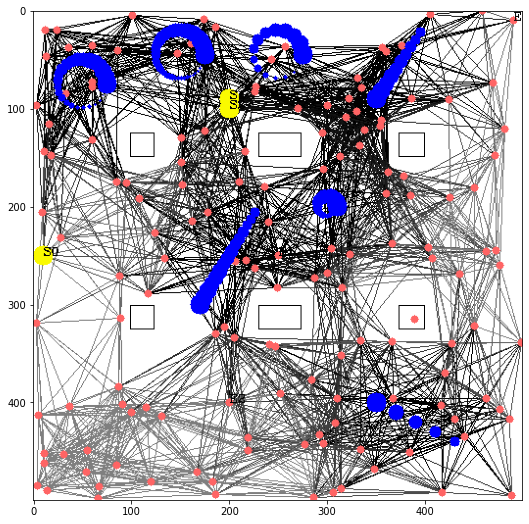

开始Dynamic Env的new_A_star_algorithm
robot 0 find its way
开始Dynamic Env的new_A_star_algorithm
robot 1 find its way
开始Dynamic Env的new_A_star_algorithm
robot 2 find its way


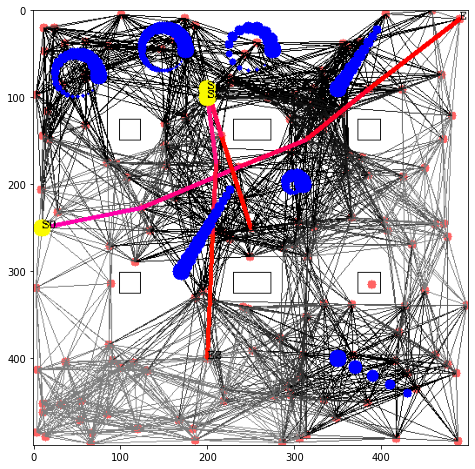

game begin


C:\Users\14020\Desktop\毕设与专利\FZU\理论工作代码和结果展示\mycode\new\my_motion_planning_toolbox.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  uo =  np.exp(- D ** 2 / (2 * ROU ** 2))  / (D ** 2) * (D_goal ** 2)


撞人或者其他机器人!
robot reach its local goal2
robot reach its local goal1
robot reach its local goal4
robot reach its local goal1
robot reach its local goal3
robot reach its local goal2
robot reach its local goal1


In [8]:
img,crowd_list,robot = world_4()
mr = DE1(img,crowd_list,robot)
PRM_A_START_APF(mr=mr,foldname="save4")

In [ ]:
img,crowd_list,robot = world_5()
mr = DE1(img,crowd_list,robot)
PRM_A_START_APF(mr=mr,foldname="save5")

In [ ]:
img,crowd_list,robot = world_6()
mr = DE1(img,crowd_list,robot)
PRM_A_START_APF(mr=mr,foldname="save6")

In [ ]:
img,crowd_list,robot = world_7()
mr = DE1(img,crowd_list,robot)
PRM_A_START_APF(mr=mr,foldname="save7")

In [ ]:
img,crowd_list,robot = world_8()
mr = DE1(img,crowd_list,robot)
PRM_A_START_APF(mr=mr,foldname="save8")

In [ ]:
img,crowd_list,robot = world_9()
mr = DE1(img,crowd_list,robot)
PRM_A_START_APF(mr=mr,foldname="save9")